In [220]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue
from random import randint

In [221]:
def showGrid(grid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 0 and 1 as elements
        Output : Heatmap grid of the corresponding maze
    '''
    grid = grid.copy()
    (height, width) = grid.shape
    grid = grid * 255                # just to match standard pixel values (0 to 255) in grayscale
    
    f = plt.figure(figsize = (width,height))
    heatmap(grid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)
    
    
    
def showGridProblem(grid, feed):
    ''' Display the maze corresponding to a binary grid
        Display "start" and "goal" position on the grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinate of the "start" and "goal"
        Output : Heatmap grid of the maze with markers
    '''
    
    grid = grid.copy()
    (height, width) = grid.shape
    grid = grid.copy() * 255
    
    grid[feed[0], feed[1]] = 64
    
    f = plt.figure(figsize = (width,height))
    heatmap(grid, vmin = 0, vmax = 255, cmap = "PiYG", cbar = False)

In [222]:
def updateGrid(grid, obs):
    grid = grid.copy()
    for i in range(len(obs)):
        x,y = obs[i][0], obs[i][1]
        if i == 0:
            grid[x,y] = 0.75
        else:
            grid[x,y] = 0.6
    return grid
    

In [223]:
def spawnFeed(grid):
    location = (randint(1,4), randint(1,4))
    while grid[location[0], location[1]] in (0.75, 1, 0.6):
        location = (randint(1,4), randint(1,4))
    
    return location

In [224]:
# Create a Graph class
class GridGraph(object):
    ''' Class to represent a Graph
        Construction : Using Edges
    '''
    def __init__(self):
        self.edges = {}
    
    def all_edges(self):
        return self.edges
    
    def neighbors(self, node):
        return self.edges[node]    

In [225]:
# Function to convert a maze to a graph
def grid_to_graph(grid):
    ''' Converts a 2D binary maze to corresponding graph
        Input : 2D NumPy array with 0 and 1 as elements
        Output : MazeGraph corresponding to input maze
    '''
    gridGraph = GridGraph()
    (height, width) = grid.shape
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            
            # Only consider blank cells as nodes
            if grid[i,j] in (0, 0.75):
                
                neighbors = []
                
                # Adjacent cell : Top
                if (i > 1) and grid[i-1,j] == 0:
                    neighbors.append(((i-1,j), 1))
                    
                # Adjacent cell : Left                
                if (j > 1) and grid[i,j-1] == 0:
                    neighbors.append(((i,j-1), 1))
                    
                # Adjacent cell : Bottom                    
                if (i < height - 2) and grid[i+1,j] == 0:
                    neighbors.append(((i+1,j), 1))

                # Adjacent cell : Right                    
                if (j < width - 2) and grid[i,j+1] == 0:
                    neighbors.append(((i,j+1), 1))

                # Insert edges in the graph
                if len(neighbors) > 0:
                    gridGraph.edges[(i,j)] = neighbors

    return gridGraph

In [235]:
# Helper functions to work with the Maze with Path

def showGridPath(grid, path, goal, snakeArr):
    ''' Display the maze corresponding to a binary grid
        Display path(s) superimposed on the binary grid 
        Input : 2D NumPy array with 0 and 1 as elements
        Input : 2D coordinates of the paths on the maze
        Output : Heatmap grid of the maze with the path
    '''
    grid = grid 
    for i in range(len(path)):
        node = path[i]
        if i != 0:
            grid[prevNode[0], prevNode[1]] = 0.6 
            grid[node[0], node[1]] = 0.75
            
            tail = snakeArr[-1]
            snakeArr = snakeArr[:-1]
            snakeArr.insert(0, node)
            grid[tail[0], tail[1]] = 0
        
            if i == len(path) - 1:
                showGrid(grid)
            else:
                showGridProblem(grid, goal)
        prevNode = node
    


In [227]:
# Breadth-First-Search (BFS) with FIFO Queue

def breadth_first_search(gridGraph, start, goal):
    ''' Function to perform BFS to find path in a graph
        Input  : Graph with the start and goal vertices
        Output : Dict of explored vertices in the graph
    '''
    frontier = queue.Queue()    # FIFO Queue for Frontier
    
    # initialization
    frontier.put(start)         # Add the start node to frontier
    explored = {}               # Dict of explored nodes {node : parentNode}
    explored[start] = None      # start node has no parent node
    processed = 0               # Count of total nodes processed
    
    while not frontier.empty():
        # get next node from frontier
        currentNode = frontier.get()
        processed += 1
        
        # stop when goal is reached
        if currentNode == goal:
            break
        
        # explore every single neighbor of current node
        for nextNode, weight in gridGraph.neighbors(currentNode):
           
            # ignore if it has already been explored, helps to ensure we get optimal soln
            if nextNode not in explored:
                
                # put new node in frontier
                frontier.put(nextNode)
                
                # assign current node as parent
                explored[nextNode] = currentNode
    
    return explored, processed


# Reconstruct the path from the Dict of explored nodes {node : parentNode}
# Intuition : Backtrack from the goal node by checking successive parents

def reconstruct_path(explored, start, goal):
    currentNode = goal             # start at the goal node
    path = []                      # initiate the blank path

    # stop when backtrack reaches start node
    while currentNode != start:
        # grow the path backwards and backtrack
        path.append(currentNode)
        currentNode = explored[currentNode]

    path.append(start)             # append start node for completeness
    path.reverse()                 # reverse the path from start to goal

    return path



In [228]:
class Snake:
    def __init__(self):
        self._length = 1
        self._posArr = [(3,3)]
        
    def grow(self):
        self._length += 1
    
    def updatePos(self, path):
        path.reverse()
        stepCount = len(path)
        snakeLength = self._length
        if snakeLength > len(path):
            self._posArr = path + self._posArr[1:snakeLength-stepCount+1]
        else:
            self._posArr = path[:snakeLength]
    
    def getPos(self):
        return self._posArr
    
    def getLength(self):
        return self._length

In [229]:
newGrid = [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

newGrid = np.array(newGrid)


Breadth-First-Search (BFS)

Total nodes in maze : 15
Total nodes visited : 8  |  53.33 %
Final path distance : 3

Path through the Maze : [(3, 3), (2, 3), (2, 4)]
Breadth-First-Search (BFS)

Total nodes in maze : 14
Total nodes visited : 8  |  57.14 %
Final path distance : 4

Path through the Maze : [(2, 4), (3, 4), (3, 3), (3, 2)]
Breadth-First-Search (BFS)

Total nodes in maze : 13
Total nodes visited : 10  |  76.92 %
Final path distance : 4

Path through the Maze : [(3, 2), (2, 2), (1, 2), (1, 1)]
Breadth-First-Search (BFS)

Total nodes in maze : 12
Total nodes visited : 3  |  25.0 %
Final path distance : 3

Path through the Maze : [(1, 1), (2, 1), (3, 1)]
Breadth-First-Search (BFS)

Total nodes in maze : 11
Total nodes visited : 11  |  100.0 %
Final path distance : 5

Path through the Maze : [(3, 1), (3, 2), (3, 3), (2, 3), (2, 4)]
Breadth-First-Search (BFS)

Total nodes in maze : 10
Total nodes visited : 3  |  30.0 %
Final path distance : 2

Path through the Maze : [(2, 4), (3, 4)

C:\Users\huang\AppData\Local\Temp\ipykernel_13416\3430344806.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize = (width,height))


KeyError: (1, 3)

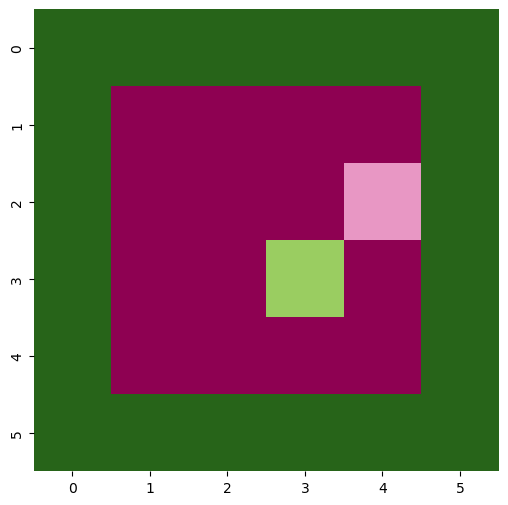

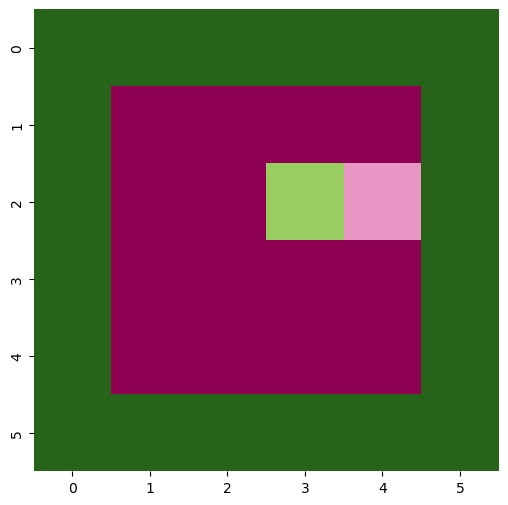

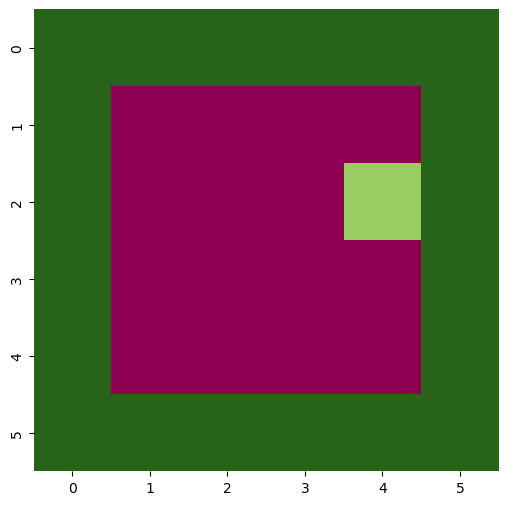

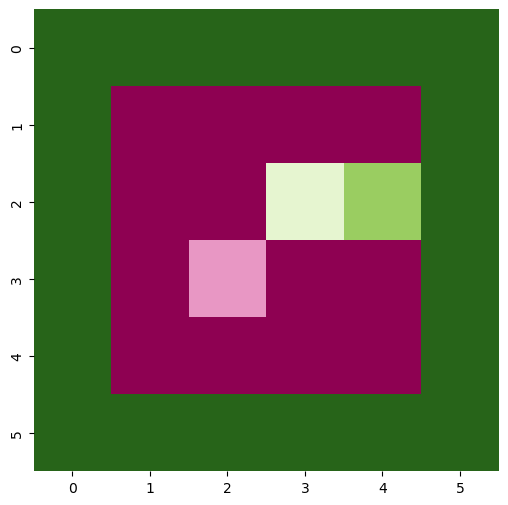

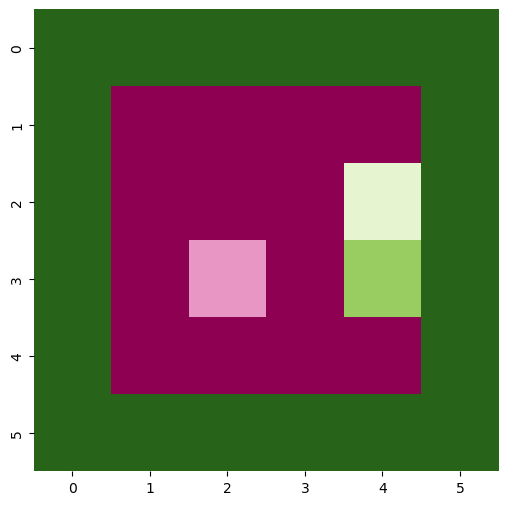

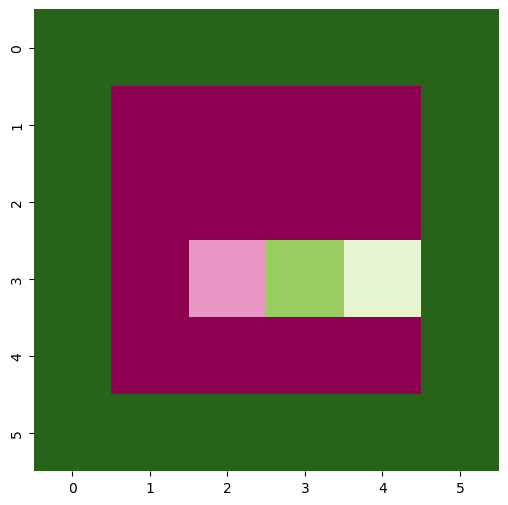

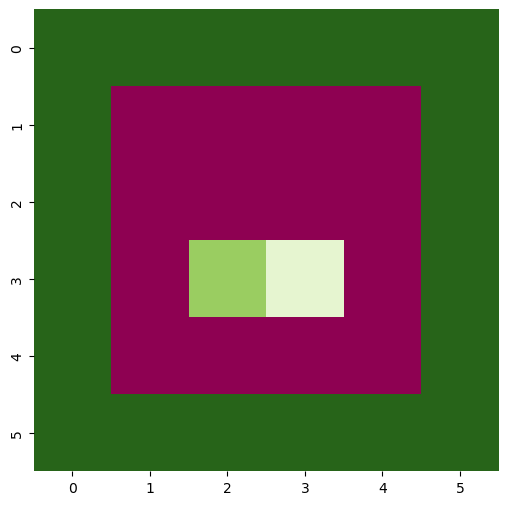

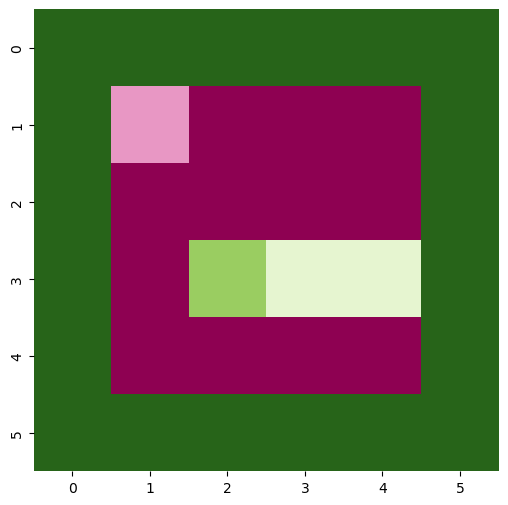

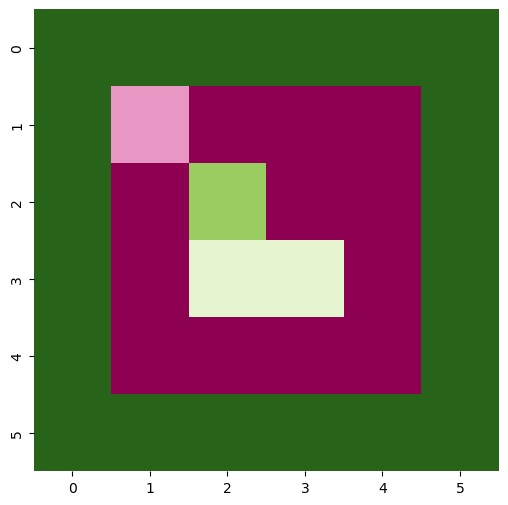

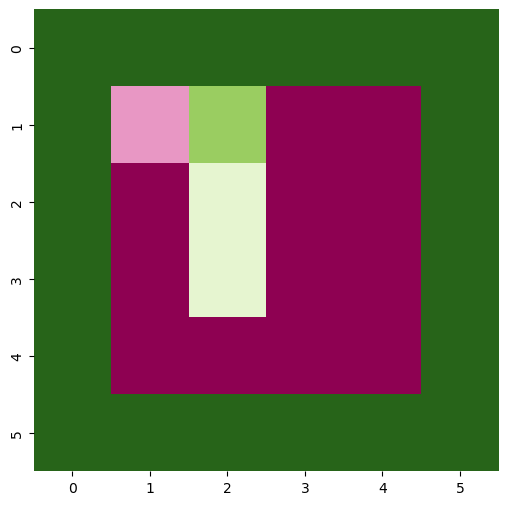

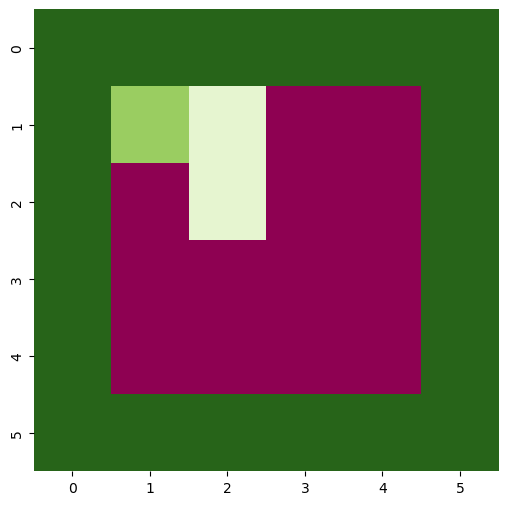

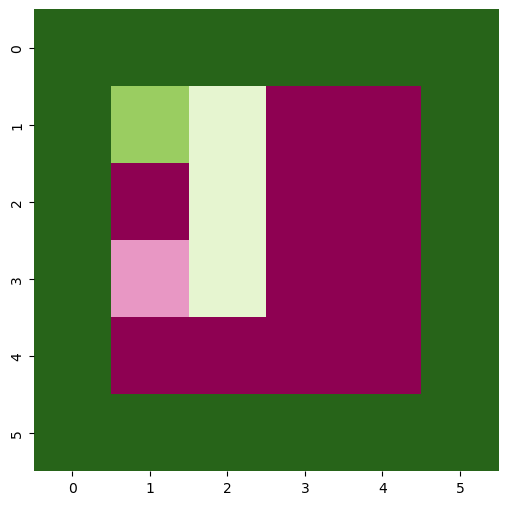

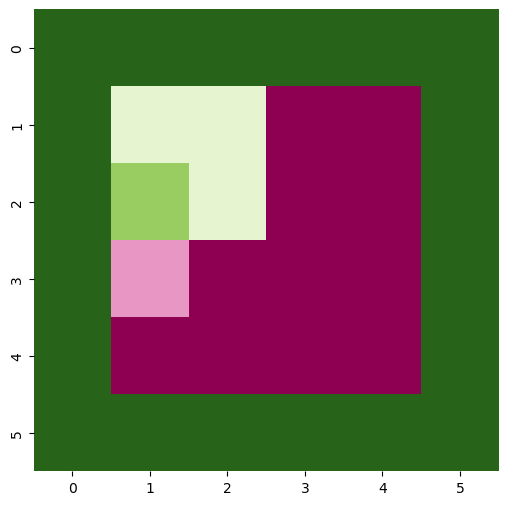

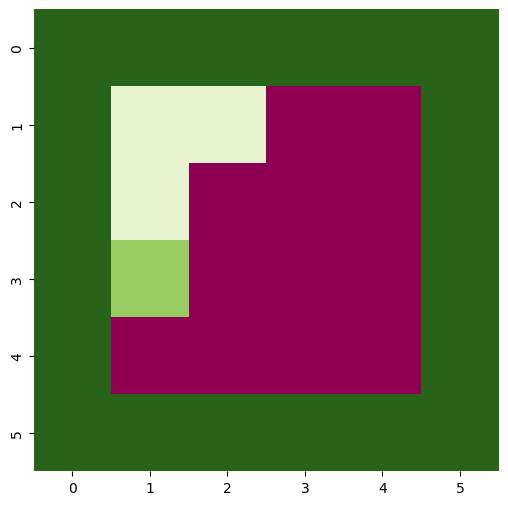

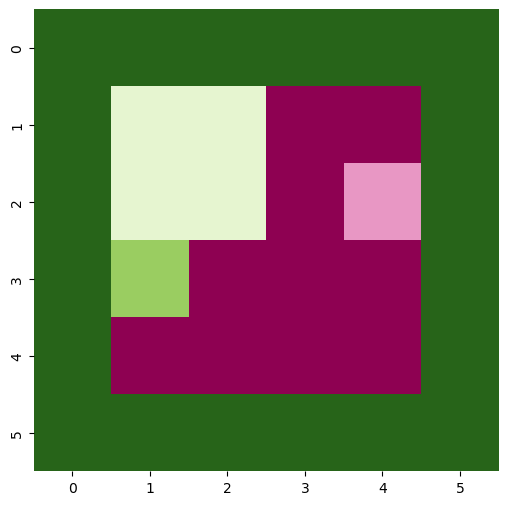

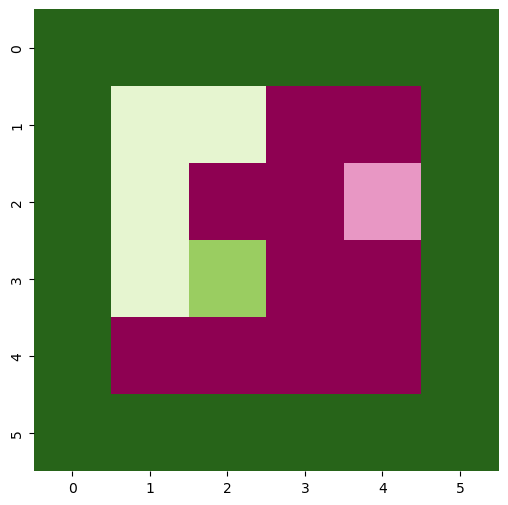

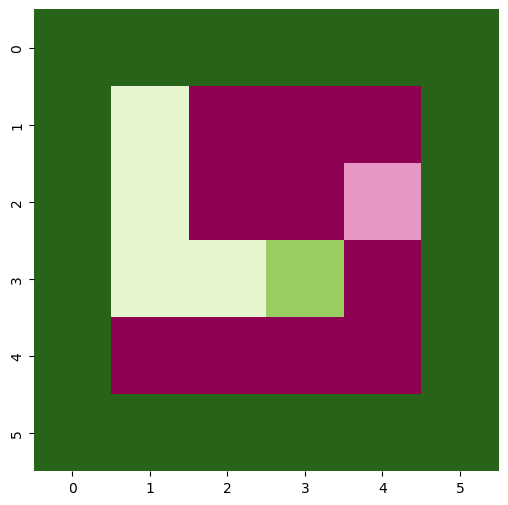

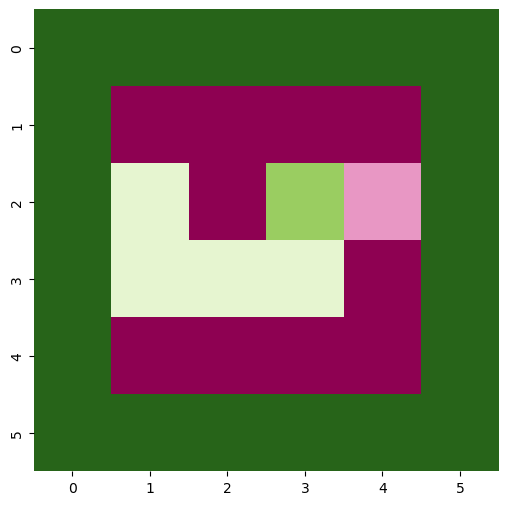

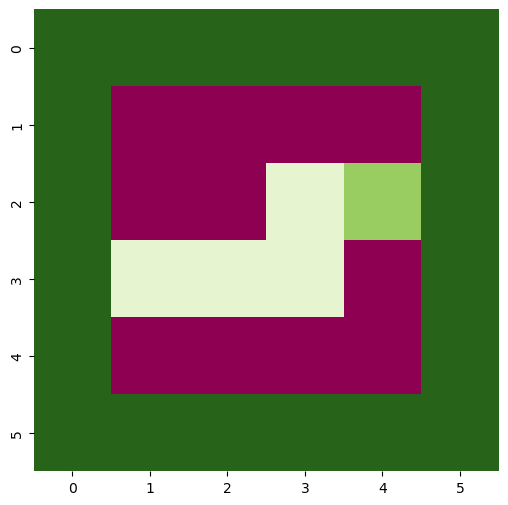

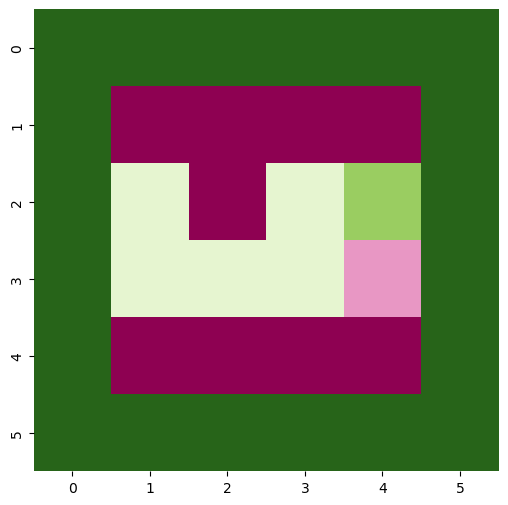

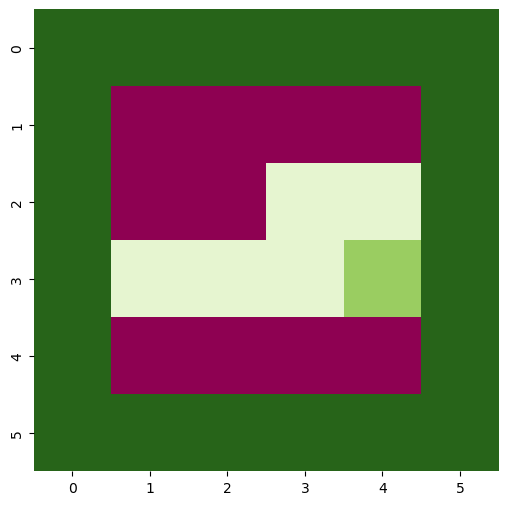

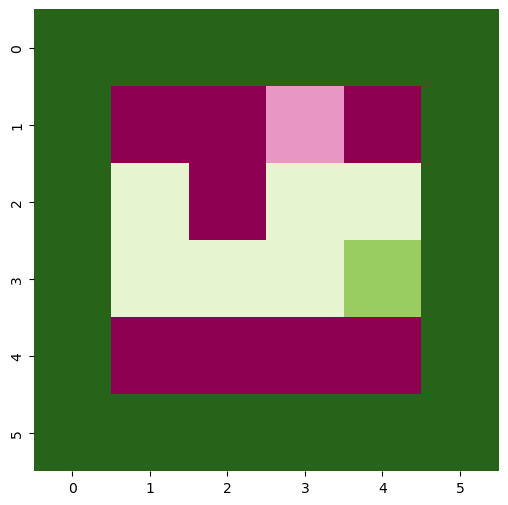

In [237]:
s1 = Snake()

while s1.getLength() < 10:
    snakeArr = s1.getPos()
    grid = updateGrid(newGrid, snakeArr)    
    feed = spawnFeed(grid)
    showGridProblem(grid, feed)
    
    # Convert the maze to a graph
    gridGraph = grid_to_graph(grid)

    # Print the edges with weights
    gridGraph.all_edges()
    
    head = snakeArr[0]

    # Run the BFS algorithm for path finding
    nodesExplored, nodesProcessed = breadth_first_search(gridGraph, start = head, goal = feed)
    path = reconstruct_path(nodesExplored, start = head, goal = feed)

    # Basic measures for the algorithm
    print("Breadth-First-Search (BFS)")
    print()

    totalNodes = np.count_nonzero(grid == 0)
    print("Total nodes in maze :", totalNodes)
    print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
    print("Final path distance :", len(path))
    print()

    # Print the path and show using helper functions
    print("Path through the Maze :", path)
    showGridPath(grid,path,feed,snakeArr)
    
    s1.grow()
    s1.updatePos(path)
    

Breadth-First-Search (BFS)

Total nodes in maze : 15
Total nodes visited : 5  |  33.33 %
Final path distance : 2

Path through the Maze : [(3, 3), (3, 4)]


TypeError: showGridPath() missing 2 required positional arguments: 'goal' and 'snakeArr'

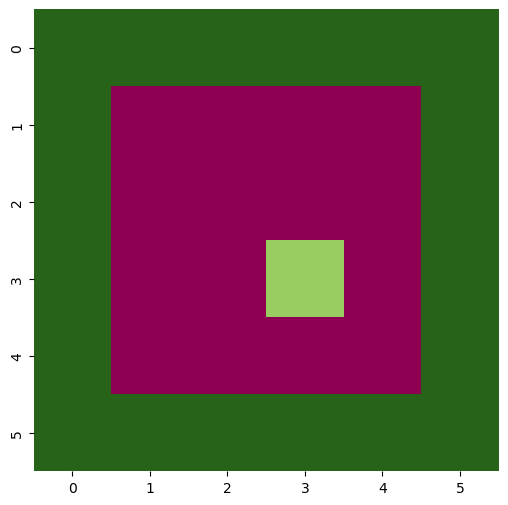

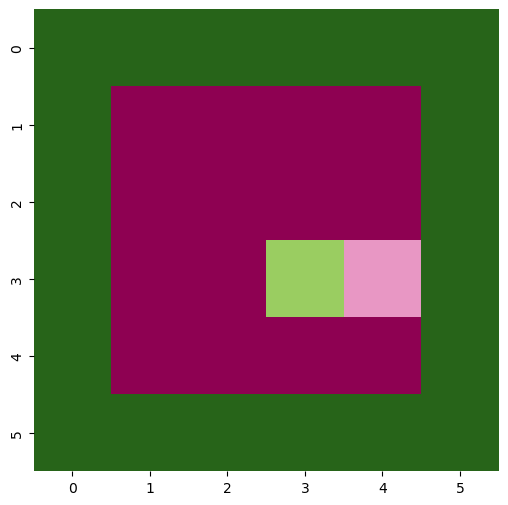

In [191]:
s1 = Snake()

while s1.getLength() < 11:
    snakeArr = s1.getPos()
    grid = updateGrid(newGrid, snakeArr)
    showGrid(grid)
    
    feed = spawnFeed(grid)
    showGridProblem(grid, feed)
    
    # Convert the maze to a graph
    gridGraph = grid_to_graph(grid)

    # Print the edges with weights
    gridGraph.all_edges()
    
    head = snakeArr[0]

    # Run the BFS algorithm for path finding
    nodesExplored, nodesProcessed = breadth_first_search(gridGraph, start = head, goal = feed)
    path = reconstruct_path(nodesExplored, start = head, goal = feed)

    # Basic measures for the algorithm
    print("Breadth-First-Search (BFS)")
    print()

    totalNodes = np.count_nonzero(grid == 0)
    print("Total nodes in maze :", totalNodes)
    print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
    print("Final path distance :", len(path))
    print()

    # Print the path and show using helper functions
    print("Path through the Maze :", path)
    showGridPath(grid,path)
    
    s1.grow()
    s1.updatePos(path)
    

In [ ]:
snakeArr = [(3,3)]
length = 1

In [ ]:
grid = updateGrid(newGrid, snakeArr)
showGrid(grid)

feed = spawnFeed(grid)
showGridProblem(grid, feed)

In [142]:
# Convert the maze to a graph
gridGraph = grid_to_graph(grid)

# Print the edges with weights
gridGraph.all_edges()

{(2, 2): [((3, 2), 1)],
 (3, 1): [((4, 1), 1), ((3, 2), 1)],
 (3, 2): [((2, 2), 1), ((4, 2), 1), ((3, 3), 1)],
 (3, 3): [((3, 2), 1), ((4, 3), 1), ((3, 4), 1)],
 (3, 4): [((3, 3), 1), ((4, 4), 1)],
 (4, 1): [((4, 2), 1)],
 (4, 2): [((3, 2), 1), ((4, 1), 1), ((4, 3), 1)],
 (4, 3): [((3, 3), 1), ((4, 2), 1), ((4, 4), 1)],
 (4, 4): [((3, 4), 1), ((4, 3), 1)]}

In [176]:
head = snakeArr[0]

# Run the BFS algorithm for path finding
nodesExplored, nodesProcessed = breadth_first_search(gridGraph, start = head, goal = feed)
path = reconstruct_path(nodesExplored, start = head, goal = feed)

# Basic measures for the algorithm
print("Breadth-First-Search (BFS)")
print()

totalNodes = np.count_nonzero(grid == 0)
print("Total nodes in maze :", totalNodes)
print("Total nodes visited :", nodesProcessed, " | ", np.round(100*(nodesProcessed/totalNodes),2), "%")
print("Final path distance :", len(path))
print()

# Print the path and show using helper functions
print("Path through the Maze :", path)
showGridPath(grid,path)

KeyError: (1, 4)

In [146]:
length += 1
print(length)



9


In [147]:
path.reverse()
stepCount = len(path)
if length > len(path):
    snakeArr = path[:length] + snakeArr[1:length-stepCount+1]
else:
    snakeArr = path[:length]
print(snakeArr)

[(4, 4), (4, 3), (4, 2), (4, 1), (3, 1), (2, 1), (1, 1), (1, 2), (1, 3)]


In [ ]:
from turtle import Screen
